In [2]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector
from math import sqrt, pi
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

from qiskit import IBMQ
IBMQ.save_account('78a4e395a27e3cce2d6bea6321d4b618bacc9db3c5f4506850b2616b7444da36b01e2c0d1f27119c77dbbde833366731ea64401e8fab2f852fa84a4c4317a11b', overwrite=True)

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
nqubits = 4
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/site-packages/requests_ntlm/requests_ntlm.py:5: CryptographyDeprecationWarning: Python 3.5 support will be dropped in the next release of cryptography. Please upgrade your Python.
  from cryptography import x509
/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/site-packages/qiskit/__init__.py:91: DeprecationWarning: Using Qiskit with Python 3.5 is deprecated as of the 0.12.0 release. Support for running Qiskit with Python 3.5 will be removed at the Python 3.5 EoL on 09/13/2020.
  "Python 3.5 EoL on 09/13/2020.", DeprecationWarning)
/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_ourense


In [12]:
driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 '+str(dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
molecule = driver.run()
freeze_list = [0]
remove_list = [-3, -2]
repulsion_energy = molecule.nuclear_repulsion_energy
num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
remove_list = [x % molecule.num_orbitals for x in remove_list]
freeze_list = [x % molecule.num_orbitals for x in freeze_list]
remove_list = [x - len(freeze_list) for x in remove_list]
remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
freeze_list += [x + molecule.num_orbitals for x in freeze_list]
ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
num_spin_orbitals -= len(freeze_list)
num_particles -= len(freeze_list)
ferOp = ferOp.fermion_mode_elimination(remove_list)
num_spin_orbitals -= len(remove_list)
shift = energy_shift + repulsion_energy
qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)

In [13]:
qubitOp.num_qubits

4

In [3]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 '+str(dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    shift = energy_shift + repulsion_energy
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(exact_solution.eigenvalues) + shift)
    #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
    #print(num_spin_orbitals, num_particles)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(backend)
    vqe_result = np.real(ret['eigenvalue']+ shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])

Interatomic Distance: 0.5 VQE Result: -7.039710213406034 Exact Energy: [-7.03973252]
Interatomic Distance: 0.6 VQE Result: -7.313344303156838 Exact Energy: [-7.31334583]
Interatomic Distance: 0.7 VQE Result: -7.500921095511624 Exact Energy: [-7.50092209]
Interatomic Distance: 0.8 VQE Result: -7.63097691472166 Exact Energy: [-7.63097825]
Interatomic Distance: 0.9 VQE Result: -7.720810794946383 Exact Energy: [-7.72081241]
Interatomic Distance: 1.0 VQE Result: -7.782240655274583 Exact Energy: [-7.7822424]
Interatomic Distance: 1.1 VQE Result: -7.823597493470569 Exact Energy: [-7.82359928]
Interatomic Distance: 1.2 VQE Result: -7.850696622713983 Exact Energy: [-7.85069838]
Interatomic Distance: 1.3 VQE Result: -7.86756160241018 Exact Energy: [-7.86756329]
Interatomic Distance: 1.4 VQE Result: -7.876999876384241 Exact Energy: [-7.87700149]
Interatomic Distance: 1.5 VQE Result: -7.881014174111126 Exact Energy: [-7.88101572]
Interatomic Distance: 1.6 VQE Result: -7.881070663347352 Exact Energ

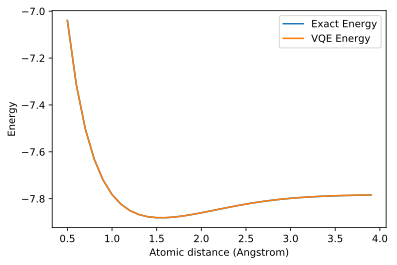

<Figure size 432x288 with 0 Axes>

In [4]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()
plt.savefig("LiH_statevector.png")

In [5]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_ourense")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 '+str(dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    shift = energy_shift + repulsion_energy
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(exact_solution.eigenvalues) + shift)
    #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
    #print(num_spin_orbitals, num_particles)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(backend)
    vqe_result = np.real(ret['eigenvalue']+ shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])

Interatomic Distance: 0.5 VQE Result: -7.030743398763911 Exact Energy: [-7.03973252]
Interatomic Distance: 0.6 VQE Result: -7.300473357998921 Exact Energy: [-7.31334583]
Interatomic Distance: 0.7 VQE Result: -7.483620485588093 Exact Energy: [-7.50092209]
Interatomic Distance: 0.8 VQE Result: -7.620656684444135 Exact Energy: [-7.63097825]
Interatomic Distance: 0.9 VQE Result: -7.701681352744174 Exact Energy: [-7.72081241]
Interatomic Distance: 1.0 VQE Result: -7.767150145404153 Exact Energy: [-7.7822424]
Interatomic Distance: 1.1 VQE Result: -7.8057480241266815 Exact Energy: [-7.82359928]
Interatomic Distance: 1.2 VQE Result: -7.8363219018981365 Exact Energy: [-7.85069838]
Interatomic Distance: 1.3 VQE Result: -7.856233836056219 Exact Energy: [-7.86756329]
Interatomic Distance: 1.4 VQE Result: -7.861836793195696 Exact Energy: [-7.87700149]
Interatomic Distance: 1.5 VQE Result: -7.872600758964802 Exact Energy: [-7.88101572]
Interatomic Distance: 1.6 VQE Result: -7.873523952004567 Exact E

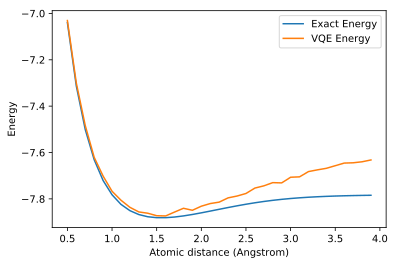

<Figure size 432x288 with 0 Axes>

In [6]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()
plt.savefig("LiH_qc.png")